In [51]:
import os
import sys
import numpy as np
import pandas as pd

In [52]:
sys.path.append('..')
from src.models import (split, node, model)
from src.data.dataset import ReducedDataset

In [53]:
import torch

In [54]:
path = os.path.join(os.getcwd(), '../data/raw')
filename = 'BO_truncated_mso_2018.pcl'
data = ReducedDataset(path, filename)
rsf = data.rsf_dataset(to_pcl=False)
X_train, T_train, E_train, X_test, T_test, E_test = data.rsf_split(to_pcl=False)

In [55]:
X_train, T_train, E_train, X_test, T_test, E_test = torch.Tensor(X_train.values), torch.tensor(T_train), E_train, torch.Tensor(X_test.values), torch.tensor(T_test), E_test

In [56]:
target_spyct_train = np.zeros((X_train.shape[0],350))
for key, value in enumerate(T_train.tolist()):
    for i in range(350):
        # if(E_train[key]==1):
        #     target_spyct_train[key][i] = np.nan
        if(i<value):
            target_spyct_train[key][i] = 1
        else:
            target_spyct_train[key][i] = 0

target_spyct_test = np.zeros((X_test.shape[0],350))
for key, value in enumerate(T_test.tolist()):
    for i in range(350):
        # if(E_test[key]==1):
        #     target_spyct_test[key][i] = np.nan
        if(i<value):
            target_spyct_test[key][i] = 1
        else:
            target_spyct_test[key][i] = 0

In [57]:
target_spyct_train = torch.Tensor(target_spyct_train)
target_spyct_test = torch.Tensor(target_spyct_test)

In [58]:
bayes_spyct = model.Spyct(bs=64)
bayes_spyct.fit(X_train, target_spyct_train)

In [59]:
preds_bayes = bayes_spyct.predict(X_test)

In [88]:
import pickle

pickle.dump(bayes_spyct, open('../models/bspyct_hecat_noncensored.pcl', 'wb'))
pickle.dump(preds_bayes, open('../models/preds_bspyct_hecat_noncensored.pcl', 'wb'))

In [60]:
preds_bayes.shape

torch.Size([9924, 100, 350])

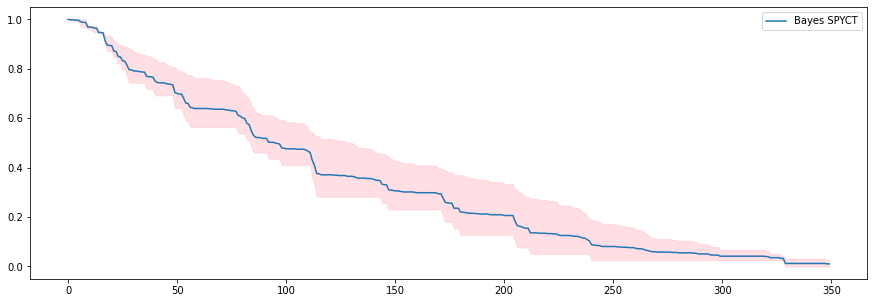

In [87]:
import matplotlib.pyplot as plt

i = 1
plt.figure(figsize=(15,5))
plt.plot(preds_bayes[i, :, :].mean(axis=0), label='Bayes SPYCT')

percentiles_10 = torch.quantile(preds_bayes[i, :, :], 0.1, axis=0)
percentiles_90 = torch.quantile(preds_bayes[i, :, :], 0.9, axis=0)

# Plot the shaded area between the 10th and 90th percentiles
plt.fill_between(range(preds_bayes.shape[-1]), percentiles_10, percentiles_90, color='pink', alpha=0.5)
plt.legend()